# HelpTheBlind





### Drive Setup

In [ ]:
from google.colab import drive 
ROOT = "/content/drive"    
print(ROOT)                
drive.mount(ROOT)

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Default title text
%cd '/content/drive/'
%ls

/content/drive
MyDrive/  Shareddrives/


In [ ]:
%cd '/content/drive/MyDrive/CS626/HelpTheBlind'
%ls 

/content/drive/MyDrive/CS626/HelpTheBlind
0o.jpg           glove.6B.300d.txt   mount.jpg
20o.jpg          HelpTheBlind.ipynb  README.md
Computed/        images/             tensorflow_shutup.py
Data/            kaggle.json         test.py
Description.mp3  model.png           TextToSpeech.py
downloadData.sh  model_weights/      train_encoded_images.p
flickr8k.zip     model_weights.h5    Video.mp4


In [ ]:
# !unzip archive.zip

### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from keras.utils import 
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.layers import add, Concatenate

import pprint
pp = pprint.PrettyPrinter(indent=3).pprint
import tensorflow as tf


# Img id to Caption Maping

In [ ]:
with open("Data/Flickr_TextData/Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

In [ ]:
captions=captions.split("\n")
len(captions)

40461

In [ ]:
pp(captions[0:5])
pp(captions[-5:])

[  '1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set '
   'of stairs in an entry way .',
   '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
   '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden '
   'playhouse .',
   '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her '
   'playhouse .',
   '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a '
   'wooden cabin .']
[  '997722733_0cb5439472.jpg#1\tA man is rock climbing high in the air .',
   '997722733_0cb5439472.jpg#2\tA person in a red shirt climbing up a rock '
   'face covered in assist handles .',
   '997722733_0cb5439472.jpg#3\tA rock climber in a red shirt .',
   '997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing '
   'wall .',
   '']


In [ ]:
captions[2]

'1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .'

In [ ]:
captions=captions[:-1]

In [ ]:
pp(captions[0:2])
pp(captions[-2:])

[  '1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set '
   'of stairs in an entry way .',
   '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .']
[  '997722733_0cb5439472.jpg#3\tA rock climber in a red shirt .',
   '997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing '
   'wall .']


In [ ]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

In [ ]:
len(captions)

40460

In [ ]:
allwords=[]

In [ ]:
def cleantext(text="A rock climber practices on a rock climbing wall ."):

  text= text.lower()

  #remove puntuations

  text = re.sub("[^a-z]+"," ",text)

  words = text.split()
   
  text = " ".join([word for word in words if len(word)>1])

  allwords.extend(list(text.split()))

  return text


In [ ]:
# img,description = captions[0].split('.jpg')
# description=cleantext(description)
# img,description

In [ ]:
ImageIdToCaption = {}

for caption in captions:
  try :
    img,description= caption.split(".jpg")
    
    if(ImageIdToCaption.get(img)== None):
      ImageIdToCaption[img]= []

    ImageIdToCaption[img].append(cleantext(description))

  except:
      print(caption)

In [ ]:
ImageIdToCaption["997722733_0cb5439472"]

['man in pink shirt climbs rock face',
 'man is rock climbing high in the air',
 'person in red shirt climbing up rock face covered in assist handles',
 'rock climber in red shirt',
 'rock climber practices on rock climbing wall']

In [ ]:
with open("Computed/ImageId2Caption.txt","w") as f:
  f.write( str(ImageIdToCaption) )

In [ ]:
# cleantext()

# Vocabulary

In [ ]:
ImageIdToCaption=None
with open("Computed/ImageId2Caption.txt","r") as f:
  ImageIdToCaption=f.read()
  ImageIdToCaption = json.loads(ImageIdToCaption.replace("'", "\""))

In [ ]:
import collections

counter= collections.Counter(allwords)
orignalVocab = dict(counter)

In [ ]:
orignalVocabSize=len(orignalVocab)
orignalVocabSize

8424

In [ ]:
newVocab = sorted(orignalVocab.items(), reverse=True, key = lambda x: x[1])
newVocab = [x for x in newVocab if x[1]>10]
all_vocab = [x[0] for x in newVocab]

In [ ]:
newVocabSize=len(newVocab)
newVocabSize

1845

In [ ]:
newVocab[-5:-1],len(newVocab)

([('drag', 11), ('motor', 11), ('seagulls', 11), ('bridesmaids', 11)], 1845)

# Train Test

In [ ]:
newVocab[:5]

[('in', 18987), ('the', 18420), ('on', 10746), ('is', 9345), ('and', 8863)]

In [ ]:
with open("Data/Flickr_TextData/Flickr_8k.trainImages.txt","r") as f:
  train=f.read()
  train= train.split('\n')[:-1]

In [ ]:
train[0:3],train[-2:]

(['2513260012_03d33305cf.jpg',
  '2903617548_d3e38d7f88.jpg',
  '3338291921_fe7ae0c8f8.jpg'],
 ['3107889179_106d223345.jpg', '2671602981_4edde92658.jpg'])

In [ ]:
with open("Data/Flickr_TextData/Flickr_8k.testImages.txt","r") as f:
  test=f.read()
  test= test.split('\n')[:-1]

In [ ]:
test[0:3],test[-2:]

(['3385593926_d3e9c21170.jpg',
  '2677656448_6b7e7702af.jpg',
  '311146855_0b65fdb169.jpg'],
 ['2623930900_b9df917b82.jpg', '3490736665_38710f4b91.jpg'])

In [ ]:
train_imgid2captions = {}

for t in train:
    x,_=t.split('.jpg')
    train_imgid2captions[x] = []
    for cap in ImageIdToCaption[x]:
        cap_to_append = "startseq " + cap + " endseq"
        train_imgid2captions[x].append(cap_to_append)

In [ ]:
pp(train_imgid2captions['2513260012_03d33305cf'])

[  'startseq black dog is running after white dog in the snow endseq',
   'startseq black dog chasing brown dog through snow endseq',
   'startseq two dogs chase each other across the snowy ground endseq',
   'startseq two dogs play together in the snow endseq',
   'startseq two dogs running through low lying body of water endseq']


#  Image Feature Extraction

In [ ]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

In [ ]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
featureExtractorModel = Model(model.input, model.layers[-2].output)

In [ ]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [ ]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = featureExtractorModel.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [ ]:
with open("./Computed/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [ ]:
with open("./Computed/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

#Preprocess Captions

In [ ]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""

ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1    

In [ ]:
ix

1846

In [ ]:
word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [ ]:
with open("./Computed/Word2SeqNumbers.pkl", "wb") as encoded_pickle:
    pickle.dump([word_to_idx,idx_to_word], encoded_pickle)

In [ ]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [ ]:
all_captions_len = []

for key in train_imgid2captions.keys():
    for cap in train_imgid2captions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


In [ ]:
pp(len(to_categorical([2], num_classes=vocab_size)[0]))

1848


In [ ]:
import tensorflow as tf

# Creating Data Generator

In [ ]:
def data_generator(train_imgid2captions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_imgid2captions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                #word to seq Numbers
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [np.array(X1), np.array(X2)], np.array(y) 
                X1, X2, y = [], [], []
                n=0

In [ ]:
!ls

0o.jpg		 glove.6B.300d.txt   mount.jpg
20o.jpg		 HelpTheBlind.ipynb  README.md
Computed	 images		     tensorflow_shutup.py
Data		 kaggle.json	     test.py
Description.mp3  model.png	     TextToSpeech.py
downloadData.sh  model_weights	     train_encoded_images.p
flickr8k.zip	 model_weights.h5    Video.mp4


In [ ]:
with open("./glove.6B.300d.txt",encoding='utf8') as f:
  embedding_index = {}
  for line in f:
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype="float")
      
      embedding_index[word] = coefs



In [ ]:
emb_dim = 300
embedding_output = np.zeros((vocab_size,emb_dim))

for word, idx in word_to_idx.items():
    embedding_vector = embedding_index.get(word)
    
    if embedding_vector is not None:
        embedding_output[idx] = embedding_vector
            

# Model

In [ ]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [ ]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=300, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
decoder1 = add([inp_img2 , inp_cap3 ])
# decoder1 = Concatenate()([inp_img2 , inp_cap3 ])

In [ ]:

decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea,input_cap], outputs=outputs)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 35, 300)      554400      ['input_7[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_6[0][0]']                
                                                                                            

In [ ]:

# Important Thing - Embedding Layer
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 35, 300)      554400      ['input_7[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_6[0][0]']                
                                                                                            

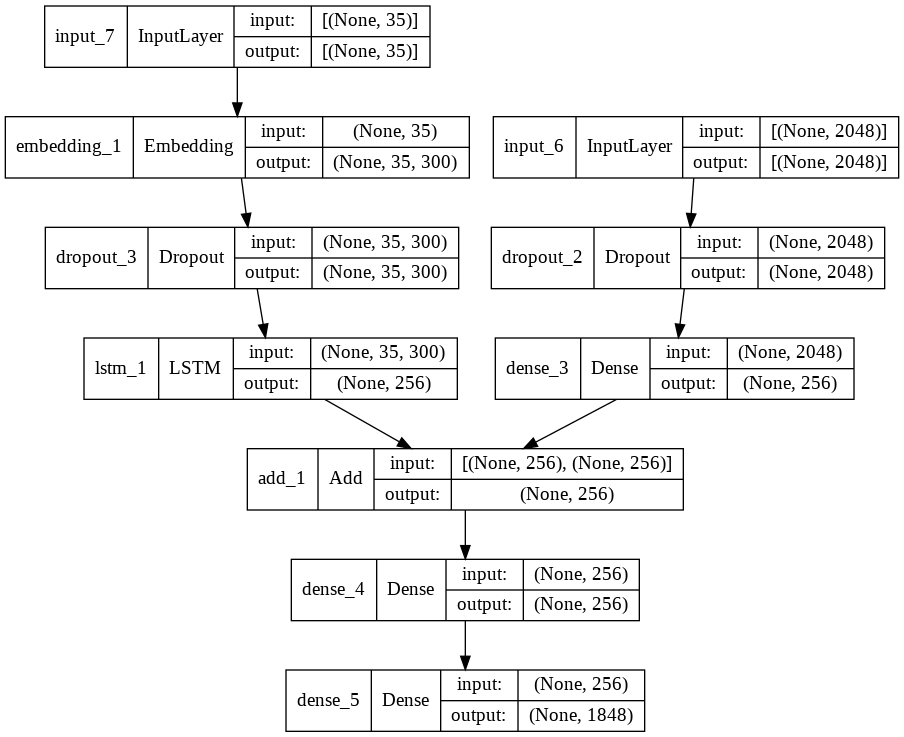

In [ ]:
# !pip install graphviz
# !pip install pydot
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:

epochs = 20
batch_size = 3
number_pics_per_batch = 3
steps = len(train_imgid2captions)//number_pics_per_batch

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 35, 300)      554400      ['input_7[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_6[0][0]']                
                                                                                            

In [ ]:
for i in range(epochs):
    generatorx = data_generator(train_imgid2captions, encoding_train, word_to_idx, max_len, number_pics_per_batch)
    model.fit_generator(generator=generatorx, epochs=1, steps_per_epoch=steps, verbose=1, shuffle=True)
    # x=next(generator)
    # x[0][0]=tf.convert_to_tensor(x[0][0])
    # x[0][1]=tf.convert_to_tensor(x[0][1])
    # x[1]=tf.convert_to_tensor(x[1])                    
    # pp(len(x))
    # model.save('./model_weights/model_' + str(i) + '.h5')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


2000/2000 [==============================] - 50s 25ms/step - loss: 2.2613


In [ ]:
model.save("model_weights/model_300d_{}.h5".format(i))
# model.save('./model_weights/model' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Prediction

In [ ]:
model = load_model("./model_weights/model19.h5")

In [ ]:
!ls

0o.jpg		 glove.6B.300d.txt   mount.jpg
20o.jpg		 HelpTheBlind.ipynb  README.md
Computed	 images		     tensorflow_shutup.py
Data		 kaggle.json	     test.py
Description.mp3  model.png	     TextToSpeech.py
downloadData.sh  model_weights	     train_encoded_images.p
flickr8k.zip	 model_weights.h5    Video.mp4


In [ ]:
!pip install gtts

In [ ]:
import tensorflow as tf

In [ ]:
def preprocess_image(img):
  img = image.load_img(img, target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  return img
def encode_image(img):
  img = preprocess_image(img)
  feature_vector = featureExtractorModel.predict(img)
  feature_vector = feature_vector.reshape(feature_vector.shape[1],)
  return feature_vector

In [ ]:
with open("./Computed/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [ ]:
with open("./Computed/Word2SeqNumbers.pkl", "rb") as Word2SeqNumbers:
    word_to_idx,idx_to_word=pickle.load( Word2SeqNumbers)

In [ ]:
max_len=35

In [ ]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
      
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

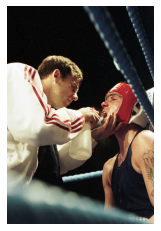

man in black shirt is sitting on bench with his arms outstretched


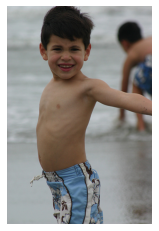

girl in blue bathing suit is running through the water


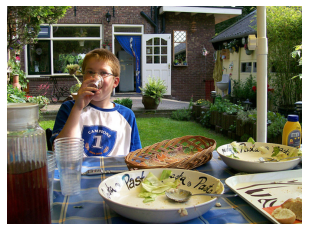

little girl in red shirt is sitting in chair with her head


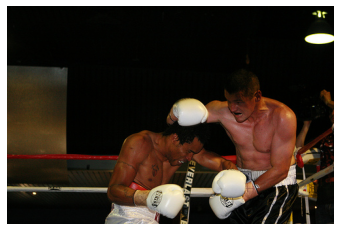

man in black shirt is sitting on bench with his feet up


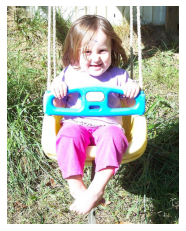

little girl in white dress and white striped shirt and white striped shirt is swinging on rope


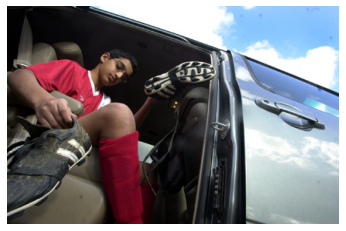

man in red shirt is sitting on the seat of boat


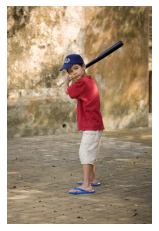

boy in red shirt is running through the grass


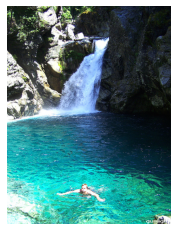

man in swimming trunks is in the ocean


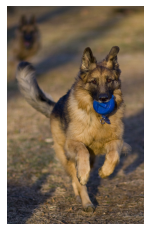

brown and black dog is running through the grass


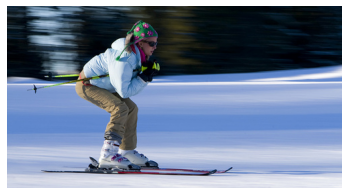

boy in red shirt is pushing another boy on swing


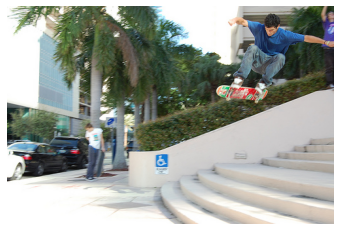

boy in blue shirt is jumping off of concrete wall


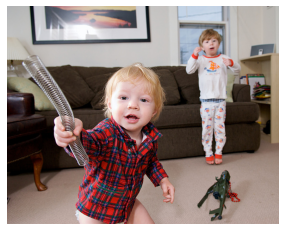

little girl in striped dress and white striped shirt is sitting on the chair


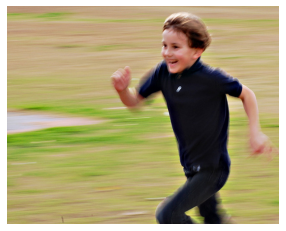

boy in blue shirt and blue jeans is running on the grass


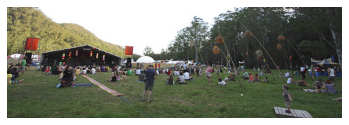

two men in uniforms are playing rugby


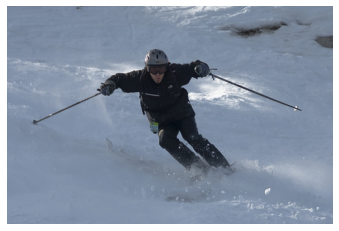

man in red jacket is skiing down snowy hill


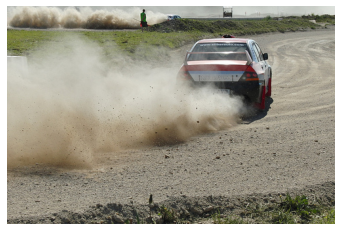

car drives car drives on dirt track


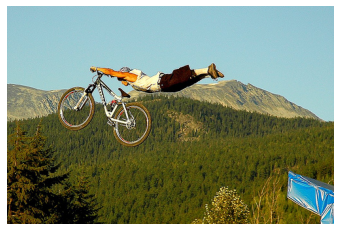

person on bike is jumping over the air


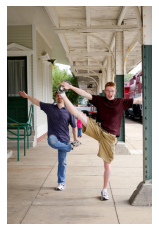

little girl in pink dress is running on the sidewalk


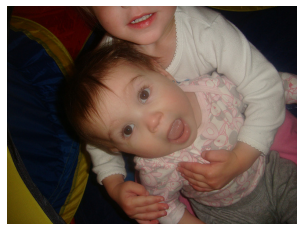

little girl in red shirt and blue cap is playing with toy


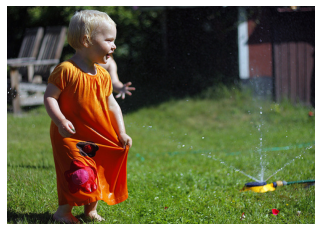

man in camouflage clothing is jogging on grass path


In [ ]:
img_id = []
captions = []
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    img_id.append(img_name.split(".jpg")[0])
    photo = encoding_test[img_name].reshape((1,2048))
    # print(img_name)
    i = plt.imread("./Data/Images/"+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    captions.append(caption)
    print(caption)

In [ ]:
img_id

['2934359101_cdf57442dc',
 '106490881_5a2dd9b7bd',
 '533713007_bf9f3e25b4',
 '3545586120_283d728a97',
 '1561658940_a947f2446a',
 '114051287_dd85625a04',
 '2774430374_fee1d793e7',
 '354642192_3b7666a2dd',
 '3216926094_bc975e84b9',
 '3159995270_17334ccb5b',
 '2306674172_dc07c7f847',
 '2274992140_bb9e868bb8',
 '3245070961_8977fdd548',
 '3191135894_2b4bdabb6d',
 '3301859683_2d5e4b40a3',
 '3578841731_f775cab089',
 '2764178773_d63b502812',
 '2884420269_225d27f242',
 '3079787482_0757e9d167',
 '3767841911_6678052eb6']

In [ ]:
captions

['man in black shirt is sitting on bench with his arms outstretched',
 'girl in blue bathing suit is running through the water',
 'little girl in red shirt is sitting in chair with her head',
 'man in black shirt is sitting on bench with his feet up',
 'little girl in white dress and white striped shirt and white striped shirt is swinging on rope',
 'man in red shirt is sitting on the seat of boat',
 'boy in red shirt is running through the grass',
 'man in swimming trunks is in the ocean',
 'brown and black dog is running through the grass',
 'boy in red shirt is pushing another boy on swing',
 'boy in blue shirt is jumping off of concrete wall',
 'little girl in striped dress and white striped shirt is sitting on the chair',
 'boy in blue shirt and blue jeans is running on the grass',
 'two men in uniforms are playing rugby',
 'man in red jacket is skiing down snowy hill',
 'car drives car drives on dirt track',
 'person on bike is jumping over the air',
 'little girl in pink dress i

In [ ]:
ImageIdToCaption["2594902417_f65d8866a8"]

['dog hops in field while another dog stands next to it',
 'one dog is jumping up at another dog in grassy field',
 'the two tan colored dogs are in field and one is jumping in the air',
 'two brown dogs in field',
 'two brown dogs play with one another in the field']

## Evaluation

In [ ]:
!pip install sumeval
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 5.5 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
from sumeval.metrics.rouge import RougeCalculator
# from sumeval.metrics.bleu import BLEUCalculator

def eval_rouges(refrence_summary,model_summary):
    #refrence_summary = "tokyo shares close up #.## percent"
    #model_summary = "tokyo stocks close up # percent to fresh record high"

    rouge = RougeCalculator(stopwords=True, lang="en")

    rouge_1 = rouge.rouge_n(
                summary=model_summary,
                references=refrence_summary,
                n=1)

    rouge_2 = rouge.rouge_n(
                summary=model_summary,
                references=[refrence_summary],
                n=2)
    
    rouge_l = rouge.rouge_l(
                summary=model_summary,
                references=[refrence_summary])

   

    #print("ROUGE-1: {}, ROUGE-2: {}, ROUGE-L: {}, ROUGE-BE: {}".format(
    #    rouge_1, rouge_2, rouge_l, rouge_be
    #).replace(", ", "\n"))
    
    return rouge_1, rouge_2,rouge_l

In [ ]:
import nltk



In [ ]:
rouge_1_sum, rouge_2_sum, rouge_l_sum, bleu_sum = 0, 0 , 0, 0 
for elem in range(len(img_id)):
  rouge_1, rouge_2, rouge_l, bleu = 0, 0, 0, 0
  for e in ImageIdToCaption[img_id[elem]]:
    rouge_1_a, rouge_2_a, rouge_l_a = eval_rouges(captions[elem], e)

    rouge_1 = max(rouge_1, rouge_1_a)
    rouge_2 = max(rouge_2, rouge_2_a)
    rouge_l = max(rouge_l, rouge_l_a)
    bleu= nltk.translate.bleu_score.sentence_bleu([captions[elem]], e)
  
  rouge_1_sum+=rouge_1
  rouge_2_sum+=rouge_2
  rouge_l_sum+=rouge_l
  bleu_sum+=bleu


rouge_1_sum/=20
rouge_2_sum/=20
rouge_l_sum/=20
bleu_sum/=20

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print("Rouge_1--------- {}\nRouge_2---------{}\nRouge_l-------{}\nBleu_Score--------------{}".format(rouge_1_sum, rouge_2_sum, rouge_l_sum, bleu_sum))

Rouge_1--------- 0.3621295371295371
Rouge_2---------0.1004761904761905
Rouge_l-------0.35212953712953715
Bleu_Score--------------0.3113770243354356


## Testing


In [ ]:
import os

"""
    Make Tensorflow less verbose
"""
try:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

    # noinspection PyPackageRequirements
    import tensorflow as tf
    from tensorflow.python.util import deprecation

    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

    # Monkey patching deprecation utils to shut it up! Maybe good idea to disable this once after upgrade
    # noinspection PyUnusedLocal
    def deprecated(date, instructions, warn_once=True):  # pylint: disable=unused-argument
        def deprecated_wrapper(func):
            return func
        return deprecated_wrapper

    deprecation.deprecated = deprecated

except ImportError:
    pass


In [ ]:
from gtts import gTTS
import os

language = 'en'
speech = gTTS(text=" ", lang=language, slow=False, tld='co.in')


def describeCaptionAsAudio(text="Caption is Empty"):
    speech.text = text
    speech.save("Description.mp3")
    # Use vlc as mp3 player
    try:
        os.system('cvlc --play-and-exit Description.mp3')
    except:
        print("[ Error Playing Audio CHECK IF CVLC IS INSTALLED ]")


if __name__ == '__main__':
    describeCaptionAsAudio()


-------------------------------------------------------------------------- 
				little girl in striped shirt and striped striped shirt is swinging on swing				
 --------------------------------------------------------------------------


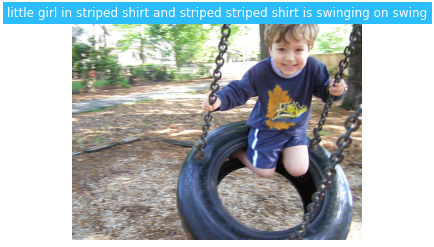

In [ ]:
#!/usr/bin/env python3

# import tensorflow_shutup
# from tf.keras.preprocessing.sequence import pad_sequences
# from tf.keras.models import load_model, Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
# import argparse
# import TextToSpeech as tts
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


# matplotlib.use('TkAgg')

# parser = argparse.ArgumentParser()
# parser.add_argument("Image", help="0o.jpg")
# args = parser.parse_args()
img = "20o.jpg"
# img = "0o.jpg"


model = load_model("./model_weights/model19.h5")

with open("./Computed/Word2SeqNumbers.pkl", "rb") as Word2SeqNumbers:
    word_to_idx, idx_to_word = pickle.load(Word2SeqNumbers)

with open("./Computed/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)


max_len = 35


featureExtractorModel = ResNet50(weights="imagenet", input_shape=(224, 224, 3))
featureExtractorModel = Model(
    featureExtractorModel.input, featureExtractorModel.layers[-2].output)


def preprocess_image(img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


def encode_image(img):
    img = preprocess_image(img)
    feature_vector = featureExtractorModel.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector


def predict_caption(photo):
    in_text = "startseq"

    for i in range(max_len):

        sequence = [word_to_idx[w]
                    for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text += ' ' + word

        if word == 'endseq':
            break

    final_caption = in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)

    return final_caption


photo = encode_image(img)
photo = photo.reshape((1, 2048))
caption = predict_caption(photo)
print("-------------------------------------"*2,
      f"\n\t\t\t\t{caption}\t\t\t\t\n", "-------------------------------------"*2)

describeCaptionAsAudio(caption)

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
i = plt.imread(img)
plt.imshow(i)
plt.axis("off")
plt.title(caption,    backgroundcolor='#2CBDFE',
          color='white')
plt.show()
